In [37]:
# Updating these names should be enough to run this notebook

notebook_fullpath = r"d:\Data\SavedNotebooks"
notebook_name = "SegmentationEvaluation"

groundtruth_fullname = r"d:\Data\ChildrensTestArrays\segmentation-test.npy"
prediction_fullname=r"d:\Data\LeaveOneOut-ChildrensPredictions\q003-pred-on-childrens.npy"

acceptable_margin_mm = 1
mm_per_pixel = 1

roc_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001,
                  0.0008, 0.0006, 0.0004, 0.0002, 0.0001,
                  0.00001, 0.000001]

In [38]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os 
import scipy.ndimage
from sklearn.metrics import roc_curve, auc

from random import sample

import evaluation_metrics

In [39]:
# Read data arrays

print("Reading ground truth from:  {}".format(groundtruth_fullname))
print("Reading predictions from:   {}".format(prediction_fullname))

groundtruth_data = np.load(groundtruth_fullname)
prediction_data = np.load(prediction_fullname)

num_groundtruth = groundtruth_data.shape[0]
num_prediction = prediction_data.shape[0]

print("\nFound {} ground truth images and {} predictions".format(num_groundtruth, num_prediction))

if num_groundtruth != num_prediction:
    print("Number of images should be equal!")
    raise

Reading ground truth from:  d:\Data\ChildrensTestArrays\segmentation-test.npy
Reading predictions from:   d:\Data\LeaveOneOut-ChildrensPredictions\q003-pred-on-childrens.npy

Found 1126 ground truth images and 1126 predictions


In [40]:
# Dilate only along image axes, not across images

def dilate_stack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

In [41]:
# Dilate ground truth

acceptable_margin_pixel = int(acceptable_margin_mm / mm_per_pixel)

acceptable_region = dilate_stack(groundtruth_data[:, :, :, 0], acceptable_margin_pixel)

In [42]:
# Computing regions for evaluation metrics

true_pos_prediction = np.minimum(groundtruth_data[:,:,:,0], prediction_data[:,:,:,1])
not_acceptable_region = 1 - acceptable_region
false_pos_prediction = np.minimum(not_acceptable_region, prediction_data[:, :, :, 1])

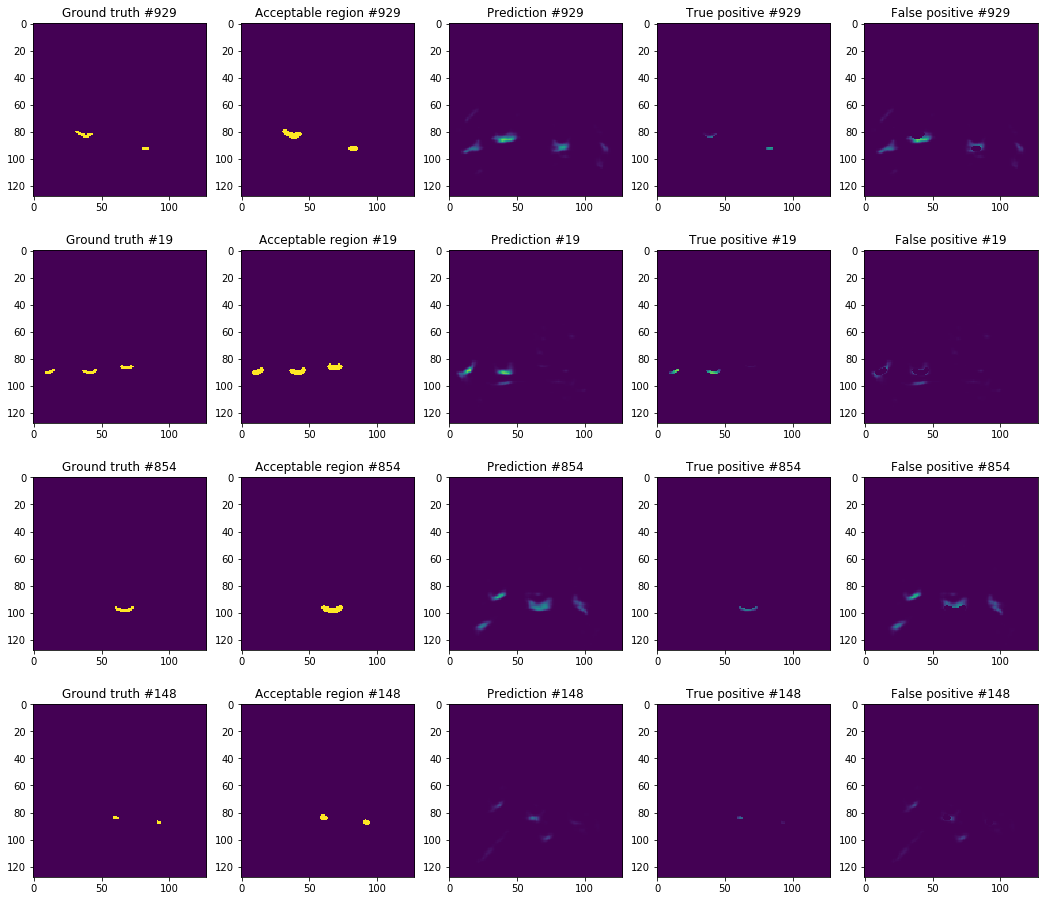

In [43]:
# Show a sample of images to check for errors

num_show = 4
num_columns = 5

all_indices = [i for i in range(num_groundtruth)]
sample_indices = sample(all_indices, num_show)

fig = plt.figure(figsize=(18, num_show * 4))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_columns, i * num_columns + 1)
    img0 = a0.imshow(groundtruth_data[sample_indices[i],:,:,0])
    a0.set_title("Ground truth #{}".format(sample_indices[i]))
    
    a1 = fig.add_subplot(num_show, num_columns, i * num_columns + 2)
    img1 = a1.imshow(acceptable_region[sample_indices[i],:,:])
    a1.set_title("Acceptable region #{}".format(sample_indices[i]))
    
    a2 = fig.add_subplot(num_show, num_columns, i * num_columns + 3)
    img2 = a2.imshow(prediction_data[sample_indices[i],:,:,1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    # c = fig.colorbar(img2, fraction=0.046, pad=0.04)
    
    a3 = fig.add_subplot(num_show, num_columns, i * num_columns + 4)
    img3 = a3.imshow(true_pos_prediction[sample_indices[i],:,:], vmin=0.0, vmax=1.0)
    a3.set_title("True positive #{}".format(sample_indices[i]))
    # c = fig.colorbar(img3, fraction=0.046, pad=0.04)
    
    a4 = fig.add_subplot(num_show, num_columns, i * num_columns + 5)
    img4 = a4.imshow(false_pos_prediction[sample_indices[i],:,:], vmin=0.0, vmax=1.0)
    a4.set_title("False positive #{}".format(sample_indices[i]))
    # c = fig.colorbar(img4, fraction=0.046, pad=0.04)
    

In [44]:
fpp = np.sum(false_pos_prediction[:,:,:])
tna = np.sum(not_acceptable_region[:,:,:])
tpp = np.sum(true_pos_prediction)
tpa = np.sum(groundtruth_data[:,:,:,0])

print("Total false positive prediction amount per image: {:.2f}".format(fpp / num_groundtruth))
print("Total true negative area per image:               {:.2f}".format(tna / num_groundtruth))
print("  {:.2f}% of the true negative area was correctly predicted".format((tna - fpp) / tna * 100))
print("")
print("Total true positive prediction amount per image: {:.2f}".format(tpp / num_groundtruth))
print("Total true position area per image:              {:.2f}".format(tpa / num_groundtruth))
print("  {:.2f}% of the true positive area was correctly predicted".format(tpp / tpa * 100))


Total false positive prediction amount per image: 32.43
Total true negative area per image:               16310.87
  99.80% of the true negative area was correctly predicted

Total true positive prediction amount per image: 10.44
Total true position area per image:              35.72
  29.23% of the true positive area was correctly predicted


In [45]:
# Calculating ROC curve data

false_positives = np.zeros(len(roc_thresholds))
true_positives = np.zeros(len(roc_thresholds))

for i in range(len(roc_thresholds)):
    threshold = roc_thresholds[i]
    prediction_thresholded = np.copy(prediction_data)
    prediction_thresholded[prediction_thresholded >= threshold] = 1.0
    prediction_thresholded[prediction_thresholded < threshold] = 0.0
    metrics = evaluation_metrics.compute_evaluation_metrics(
        prediction_thresholded, groundtruth_data, acceptable_margin_mm=acceptable_margin_mm, mm_per_pixel=mm_per_pixel)
    true_negative_area_perc = metrics[evaluation_metrics.TRUE_NEGATIVE_AREA_PERCENT]
    false_positives[i] = (100 - true_negative_area_perc) / 100.0
    true_positives[i] = metrics[evaluation_metrics.TRUE_POSITIVE_AREA_PERCENT] / 100.0

In [46]:
# Goodness is defined as distance from the diagonal of the ROC curve

goodnesses = np.zeros(len(roc_thresholds))
for i in range(len(roc_thresholds)):
    crossprod = np.cross((1.0, 1.0), (false_positives[i], true_positives[i]))
    goodnesses[i] = np.linalg.norm(crossprod)/np.linalg.norm([1.0, 1.0])

best_threshold_index = np.argmax(goodnesses)
print("Best threshold:           {}".format(roc_thresholds[best_threshold_index]))
print("Best true positive rate:  {}".format(true_positives[best_threshold_index]))
print("Best false positive rate: {}".format(false_positives[best_threshold_index]))

Best threshold:           0.002
Best true positive rate:  0.9658429871227564
Best false positive rate: 0.054719129785427326


AUC = 0.886358645231231


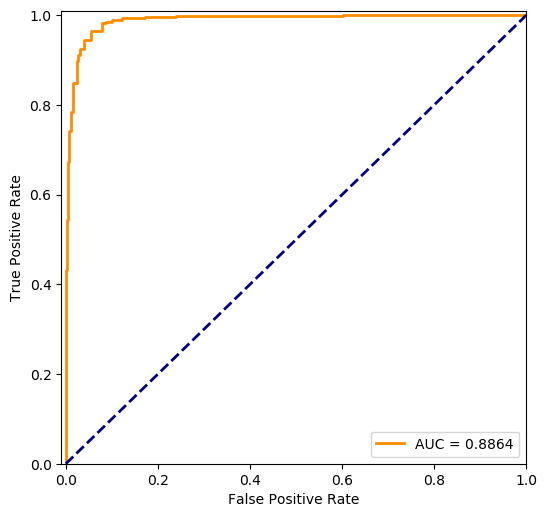

In [47]:
area = auc(false_positives, true_positives)

fps = np.zeros(len(false_positives) * 2)
tps = np.zeros(len(false_positives) * 2)

for i in range(len(false_positives)):
    fps[i*2] = false_positives[i]
    tps[i*2] = true_positives[i]
    if i == len(false_positives) - 1:
        fps[i*2+1] = 1.0
        tps[i*2+1] = true_positives[i]
    else:
        fps[i*2+1] = false_positives[i+1]
        tps[i*2+1] = true_positives[i]

plt.figure(num=None, figsize=(6,6), dpi=100)
plt.plot(fps, tps, color='darkorange', lw=2, label='AUC = %0.4f'%area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.legend(loc="lower right")

print("AUC = {}".format(area))

In [48]:
# Archive model and notebook with unique filenames based on timestamps

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if not os.path.exists(notebook_fullpath):
    os.makedirs(notebook_fullpath)
    print("Creating folder: {}".format(notebook_fullpath))

notebook_file_name = notebook_name + "_" + timestamp + ".html"
notebook_fullname = os.path.join(notebook_fullpath, notebook_file_name)

In [49]:
# Save the notebook, so pictures are archived

from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [50]:
# Archiving the notebook as a single html file

os.system("jupyter nbconvert --to html "+ notebook_name +" --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\SavedNotebooks\SegmentationEvaluation_2019-09-24_14-01-28.html
